<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting/blob/main/myStocks_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
import os

# Install es_MX
!/usr/share/locales/install-language-pack en_IN
!dpkg-reconfigure locales

# Restart Python process to pick up the new locales
os.kill(os.getpid(), 9)
'''

'\nimport os\n\n# Install es_MX\n!/usr/share/locales/install-language-pack en_IN\n!dpkg-reconfigure locales\n\n# Restart Python process to pick up the new locales\nos.kill(os.getpid(), 9)\n'

In [2]:
# notebook start time
import time
import datetime
import pytz

start_time = time.time()

# function to print date timestamp
def print_date_time():
  tz_NY = pytz.timezone('Asia/Kolkata')
  datetime_NY = datetime.datetime.now(tz_NY)
  print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

print_date_time()

Run date time (IST): 2024-06-27 16:18:50


In [3]:
# function to get booked and reserved amount
def get_amt():
  py_booked_amt = 304000 + 1007000
  cy_booked_amt = 152000 + 98860 + 33000
  reserve_amt = 2500 + 113000 - 79000 - 34400 + 140000 - 80000 - 30000
  total_booked_amt = py_booked_amt + cy_booked_amt
  return total_booked_amt, reserve_amt, cy_booked_amt, py_booked_amt

total_booked_amt, reserve_amt, cy_booked_amt, py_booked_amt = get_amt()

gen_output = 0

In [4]:
# install libraries
!pip install yfinance
!pip install pandas-ta
!pip install pyxirr
#!pip install talib-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=652c9ee3def7b2df44a3e553df90dc330410ccd368dd3e4d610620a281f193bb
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.2/541.2 kB 8.6 MB/s eta 0:00:00


In [5]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta
import locale
locale.setlocale(locale.LC_MONETARY, 'en_IN')

from google.colab import data_table

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [6]:
# function to set start and end date
def get_start_end_date():
  start_date = (datetime.date.today() + datetime.timedelta(days=-365)).strftime('%Y-%m-%d')
  end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
  return start_date, end_date

# function to fetch my portfolio csv
def get_mypfs_df():
  mypfs_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/myPortfolioStocks.csv')
  return mypfs_df

# function to fetch my prospects csv
def get_mypps_df():
  mypps_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/myProspectsScrips.csv')
  return mypps_df

# function to fetch screener data
def get_myscreen_df():
  myscreen_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/myScreenerDB.csv')
  return myscreen_df

# function to get the stock ids
def get_stock_ids(df_pf):
  stock_n100 = df_pf['Symbol'].unique()

  exclude = ['CADILAHC','MMTC', 'MASFIN']

  stock_ids = df_pf[~df_pf['Symbol'].isin(exclude) ]['Symbol'].unique()

  #mypf = mypf[mypf.Forecast.notnull()]
  #stock_ids = mypf['Symbol'].unique()

  stock_ids.sort()
  return stock_ids

# get features from screener data
def get_screener_features():
  myscreen_df = get_myscreen_df()
  cols = ['Symbol', 'EPS', 'MedPE', 'ROCE%', 'ROE%', 'CapType']
  return myscreen_df[cols]

In [7]:
# function to get stock technicals
def stock_prec_dev(stock_symbol):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = yfin.Ticker(stock_symbol + '.NS').history(period='max', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]

    stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Symbol'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)
    stock_df['Min'] = round(min(stock_df['Close']),2)
    stock_df.ta.rsi(append=True)
    stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
    stock_df['Prev_Close'] = stock_df['Close'].shift(1)
    stock_df.drop(['Open', 'Low', 'High', 'Volume'], axis=1, inplace=True)
    stock_df = stock_df.tail(1)

    return stock_df

# function to compute stock attributes
def get_common_features(stock_ids, df_mypf):

  df_prec_dev = pd.DataFrame()
  df_tmp = get_screener_features()

  for stock_id in stock_ids:
      tmp = stock_prec_dev(stock_id)
      tmp = tmp.reset_index()
      df_prec_dev = pd.concat([df_prec_dev, tmp], ignore_index = True)
  df_prec_dev = pd.merge(df_prec_dev, df_mypf, on= 'Symbol')
  df_prec_dev = pd.merge(df_prec_dev, df_tmp, on= 'Symbol', how='left')
  df_prec_dev['Curr_PE'] = round(df_prec_dev['Close']/df_prec_dev['EPS'],1)
  df_prec_dev['Dev%_PE'] = round((df_prec_dev['Curr_PE'] - df_prec_dev['MedPE'])*100/df_prec_dev['MedPE'],2)
  return df_prec_dev

# function to arrange stock features
def arrange_features(df_stocks, common_cols, diff_cols):
  df_stocks_common = df_stocks[common_cols].drop_duplicates()
  df_stocks_diff = df_stocks[diff_cols]
  df_stocks_diff['Investment'] = df_stocks_diff['AvgCost'] * df_stocks_diff['Shares']
  df_stocks_diff = df_stocks_diff.groupby(['Symbol'])[['Shares', 'Investment']].aggregate(['sum']).reset_index()
  df_stocks_diff.columns = ['Symbol', 'Shares', 'Investment']
  df_stocks_diff['AvgCost'] = round(df_stocks_diff['Investment']/df_stocks_diff['Shares'],2)
  df_stocks = pd.merge(df_stocks_diff, df_stocks_common, on='Symbol')
  return df_stocks

In [8]:
# function to get portfolio features

def get_portfolio_features(df_common_features):

  #df_common_features["Target"] = df_common_features["Target"].fillna(df_common_features["Max"])
  df_common_features['NTT'] = np.where(df_common_features['Strategy']== 'NTT', df_common_features["Target"], df_common_features['Max'])
  df_common_features['LTT'] = np.where(df_common_features['Strategy']== 'BTT', df_common_features["Target"], df_common_features['Max'])
  df_common_features['BOL'] = df_common_features['Min']

  tmp_df = df_common_features[df_common_features['Symbol'].isin(mypf_df[mypf_df['InPortfolio'] != 'NA'].Symbol.values)]
  print('qualified stocks: '+str(len(tmp_df['Symbol'].unique())))
  tmp_df1 = tmp_df[tmp_df['LatestQtr'] == 1]
  print('with latest results: '+str(len(tmp_df1['Symbol'].unique())))
  tmp_df1 = tmp_df1[tmp_df1['StarStock'] == 1]
  print('still star stocks: '+str(len(tmp_df1['Symbol'].unique())))
  tmp_df['Investment'] = tmp_df['AvgCost'] * tmp_df['Shares']
  tmp_df['Current'] = round(tmp_df['Close'] * tmp_df['Shares'],0)
  tmp_df['Previous'] = tmp_df['Prev_Close'] * tmp_df['Shares']
  tmp_df['EstimatedST'] = tmp_df['NTT'] * tmp_df['Shares']
  tmp_df['EstimatedLT'] = tmp_df['LTT'] * tmp_df['Shares']
  tmp_df['Current P/L'] = round((tmp_df['Current'] - tmp_df['Investment']),0)
  tmp_df['Today P/L%'] = round((tmp_df['Current'] - tmp_df['Previous'])*100/tmp_df['Previous'],2)
  tmp_df['Current P/L%'] = round((tmp_df['Current'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['EstimatedST P/L%'] = round((tmp_df['EstimatedST'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['EstimatedLT P/L%'] = round((tmp_df['EstimatedLT'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['NTT%'] = round((tmp_df['NTT'] - tmp_df['Close'])*100/tmp_df['Close'],2)
  tmp_df['LTT%'] = round((tmp_df['LTT'] - tmp_df['Close'])*100/tmp_df['Close'],2)
  tmp_df['Gained%'] = round((tmp_df['Close'] - tmp_df['BOL'])*100/tmp_df['BOL'],2)
  investment = round(sum(tmp_df['AvgCost']*tmp_df['Shares']),0)
  current = round(sum(tmp_df['Close']*tmp_df['Shares']),0)
  tmp_df['InitAlloc%'] = round(tmp_df['Investment']*100/investment,2)
  tmp_df['CurrAlloc%'] = round(tmp_df['Current']*100/current,2)
  tmp_df['FTT'] = tmp_df['LTT']
  tmp_df.loc[tmp_df['Strategy'] == 'NTT', 'FTT'] = tmp_df['NTT']
  tmp_df['FTT%'] = tmp_df['LTT%']
  tmp_df.loc[tmp_df['Strategy'] == 'NTT', 'FTT%'] = tmp_df['NTT%']
  tmp_df['OTT%'] = round((tmp_df['FTT'] - tmp_df['AvgCost'])*100/tmp_df['AvgCost'],2)
  tmp_df['RRR Ind'] = round(tmp_df['Current P/L%']/tmp_df['FTT%'],2)
  tmp_df['Risk Ind'] = round(tmp_df['Current P/L%']*tmp_df['CurrAlloc%'],0)

  return tmp_df

# function to print portfolio features
def print_portfolio_stats(df_portfolio_features):
  investment = round(sum(df_portfolio_features['AvgCost']*df_portfolio_features['Shares']),0) + reserve_amt -total_booked_amt
  current = round(sum(df_portfolio_features['Close']*df_portfolio_features['Shares']),0) + reserve_amt
  previous = round(sum(df_portfolio_features['Prev_Close']*df_portfolio_features['Shares']),0) + reserve_amt
  cy_invested = investment + total_booked_amt - cy_booked_amt

  today_pnl_amount = current-previous
  today_pnl_percentage = round((current-previous)*100/previous,2)

  curr_pnl_amount = current-investment -total_booked_amt
  curr_pnl_percentage = round((curr_pnl_amount)*100/(cy_invested),2)

  cy_pnl_amount = cy_booked_amt + curr_pnl_amount
  cy_pnl_percentage = round((cy_pnl_amount)*100/cy_invested,2)

  overall_pnl_amount = total_booked_amt + curr_pnl_amount
  overall_pnl_percentage = round((overall_pnl_amount)*100/investment,2)

  estimate_st = round(sum(df_portfolio_features['NTT']*df_portfolio_features['Shares']),0)  + reserve_amt
  est_st_pnl_amount = estimate_st-current
  est_st_pnl_percentage = round((est_st_pnl_amount)*100/current,2)

  estimate_lt = round(sum(df_portfolio_features['LTT']*df_portfolio_features['Shares']),0)  + reserve_amt
  est_lt_pnl_amount = estimate_lt-current
  est_lt_pnl_percentage = round((est_lt_pnl_amount)*100/current,2)

  total_profit = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Investment']),0)
  total_loss = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Investment']),0)

  cy_booked_percentage = round((cy_booked_amt)*100/current,2)
  py_booked_percentage = round((py_booked_amt)*100/investment,2)
  total_booked_percentage = round((total_booked_amt)*100/investment,2)

  print('-------------------')
  print('Initial Investment: ', locale.currency((investment), grouping=True))
  print('CY Investment: ', locale.currency(cy_invested, grouping=True))
  print('Reserve: ', locale.currency(reserve_amt, grouping=True))
  print('Current: ',  locale.currency((current), grouping=True))
  print('-------------------')
  print('Today PnL: '+ '{} ({}%)'.format(locale.currency(today_pnl_amount, grouping=True), today_pnl_percentage))
  print('Current PnL: '+ '{} ({}%)'.format(locale.currency(curr_pnl_amount, grouping=True), curr_pnl_percentage))
  print('CY Booked + Current PnL: '+ '{} ({}%)'.format(locale.currency(cy_pnl_amount, grouping=True), cy_pnl_percentage))
  print('-------------------')
  print('Total profit: ', locale.currency(total_profit, grouping=True))
  print('Total loss: ', locale.currency(total_loss, grouping=True))
  print('-------------------')
  print('Total Booked + Current PnL: '+ '{} ({}%)'.format(locale.currency(overall_pnl_amount, grouping=True), overall_pnl_percentage))
  print('Total Booked PnL: '+ '{} ({}%)'.format(locale.currency(total_booked_amt, grouping=True), total_booked_percentage))
  print('Curr Year Booked PnL: '+ '{} ({}%)'.format(locale.currency(cy_booked_amt, grouping=True), cy_booked_percentage))
  print('Prev Year Booked PnL: '+ '{} ({}%)'.format(locale.currency(py_booked_amt, grouping=True), py_booked_percentage))
  print('===================')
  print('Est NTT: ',  locale.currency(estimate_st, grouping=True))
  print('Est NTT PnL: '+ '{} ({}%)'.format(locale.currency(est_st_pnl_amount, grouping=True), est_st_pnl_percentage))
  print('-------------------')
  print('Est LTT: ',  locale.currency(estimate_lt, grouping=True))
  print('Est LTT PnL: '+ '{} ({}%)'.format(locale.currency(est_lt_pnl_amount, grouping=True), est_lt_pnl_percentage))

  from datetime import date
  from pyxirr import xirr

  myinvs = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/myInvestments.csv')

  dates = myinvs['Date'].values
  dates = np.append(dates, datetime.date.today().strftime('%d-%b-%y'))
  investment = myinvs['Investment'].values
  print('===================')
  print('Deployed: ', locale.currency(-sum(investment), grouping=True))

  investment = np.append(investment, current)
  print('Current: ', locale.currency(current, grouping=True))

  dates= pd.to_datetime(dates)
  cagr = round(xirr(pd.DataFrame({"dates": dates, "amounts": investment}))*100,2)
  print('CAGR/XIRR %: '+'{}%'.format(cagr))

In [9]:
# get start and end date
start_date, end_date = get_start_end_date()

# get portfolio and prospects data
mypfs_df = get_mypfs_df()
mypps_df = get_mypps_df()

# merge above datasets
mypf_df = pd.merge(mypfs_df, mypps_df, on="Symbol")

#myts = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Tradevesting/myTransactionsReport.csv')

# seggregate dm and sv portfolio
dm_pf = mypf_df[mypf_df['InPortfolio'] == 'DM']
sv_pf = mypf_df[mypf_df['InPortfolio'] == 'SV']

# build portfolio stock dataframe
dm_stocks = get_stock_ids(dm_pf)
sv_stocks = get_stock_ids(sv_pf)
df_stocks = pd.concat([dm_pf,sv_pf], ignore_index = True)

# arrange common and diff stock features
common_cols = ['Symbol', 'Target', 'Criteria', 'Strategy', 'TFrame', 'LatestQtr', 'StarStock', 'BizFinTech', 'Conviction', 'Category']
diff_cols = ['Symbol', 'AvgCost', 'Shares']
df_stocks = arrange_features(df_stocks, common_cols, diff_cols)

# get common features
stock_ids = df_stocks['Symbol'].values
df_common_features = get_common_features(stock_ids, df_stocks)

df_common_features.reset_index(drop=True, inplace=True)
df_common_features.drop(['Date'], axis=1, inplace=True)

# get and print portfolio features
df_portfolio_features = get_portfolio_features(df_common_features)
print_portfolio_stats(df_portfolio_features)

qualified stocks: 79
with latest results: 78
still star stocks: 47
-------------------
Initial Investment:  ₹85,92,970.00
CY Investment:  ₹99,03,970.00
Reserve:  ₹32,100.00
Current:  ₹1,06,09,156.00
-------------------
Today PnL: -₹22,898.00 (-0.22%)
Current PnL: ₹4,21,326.00 (4.25%)
CY Booked + Current PnL: ₹7,05,186.00 (7.12%)
-------------------
Total profit:  ₹8,13,536.00
Total loss:  -₹3,92,209.00
-------------------
Total Booked + Current PnL: ₹20,16,186.00 (23.46%)
Total Booked PnL: ₹15,94,860.00 (18.56%)
Curr Year Booked PnL: ₹2,83,860.00 (2.68%)
Prev Year Booked PnL: ₹13,11,000.00 (15.26%)
Est NTT:  ₹1,47,12,332.00
Est NTT PnL: ₹41,03,176.00 (38.68%)
-------------------
Est LTT:  ₹1,99,01,931.00
Est LTT PnL: ₹92,92,775.00 (87.59%)
Deployed:  ₹86,02,000.00
Current:  ₹1,06,09,156.00
CAGR/XIRR %: 25.7%


In [10]:
# select the features to analyse
cols = ['Symbol', 'Close', 'AvgCost','FTT',  'Dev%_200', 'Dev%_PE', 'RSI_14', 'Shares',  'Current', 'Current P/L','Today P/L%', 'Current P/L%', 'FTT%', 'OTT%','Gained%', 'CurrAlloc%', 'RRR Ind',  'Risk Ind', 'Criteria', 'Strategy','LatestQtr', 'StarStock', 'Conviction', 'Category']
df_portfolio_features = df_portfolio_features[cols]

if gen_output == 1:
  from google.colab import drive
  drive.mount('/content/drive')
  df_portfolio_features.to_csv('/content/drive/My Drive/data/stocks/myStocks-Portfolio-Analysis.csv', index=False)

In [11]:
# all portfolio
df_portfolio_features = df_portfolio_features.sort_values(by = 'FTT%', ascending=True)
data_table.DataTable(df_portfolio_features, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
12,BAYERCROP,6653.90,4346.57,7031.00,21.80,16.39,73.0,16,106462.0,36917.0,...,57.96,1.01,9.36,54.0,AV40N,BTT,1,1,M,CHEMICALS
53,PIDILITIND,3143.95,2482.94,3483.00,15.54,2.33,57.0,58,182349.0,38338.0,...,36.97,1.72,2.47,46.0,AV40,BTT,1,1,H,CHEMICALS
17,CAMS,3551.10,2571.78,3940.00,23.22,12.84,53.0,72,255679.0,70511.0,...,67.97,2.42,3.48,92.0,AVR,NTT,1,1,M,MISC
16,BRITANNIA,5430.30,4515.41,6154.00,10.66,10.75,60.0,17,92315.0,15553.0,...,23.49,0.87,1.52,18.0,AAR,BTT,1,1,L,FMCG
51,NEOGEN,1672.45,1489.90,1901.29,11.42,79.29,72.0,68,113727.0,12414.0,...,40.05,1.08,0.90,13.0,AAR,ATH,1,0,L,CHEMICALS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,RAJESHEXPO,280.65,517.65,583.00,-22.69,51.81,40.0,265,74372.0,-62805.0,...,6.49,0.70,-0.42,-32.0,AV40N,NTT,1,0,M,JEWELLERY
68,TANLA,945.60,969.42,2019.39,-2.82,-20.52,56.0,166,156970.0,-3954.0,...,17.54,1.48,-0.02,-4.0,AAR,ATH,1,1,L,IT
76,VAIBHAVGBL,311.85,356.39,670.00,-23.57,13.83,37.0,214,66736.0,-9531.0,...,12.22,0.63,-0.11,-8.0,AVR,NTT,1,0,M,JEWELLERY
74,UJJIVANSFB,43.78,59.50,106.00,-18.93,-43.51,28.0,1700,74426.0,-26724.0,...,16.93,0.70,-0.19,-18.0,AV40N,BTT,1,1,M,BANKS


In [12]:
# candidates to refill
tmp_df = df_portfolio_features[(df_portfolio_features['Current P/L%']>5) & (df_portfolio_features['Current P/L%']<10) & (df_portfolio_features['CurrAlloc%']<2)].sort_values(by = 'FTT%', ascending=False)
data_table.DataTable(tmp_df, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
31,HDFCLIFE,593.25,560.54,897.0,-3.22,-10.04,60.0,263,156025.0,8603.0,...,11.38,1.48,0.11,9.0,AV40,BTT,1,0,H,INSURANCE
28,HATHWAY,21.64,19.74,31.4,3.05,65.10,49.0,4000,86560.0,7600.0,...,47.71,0.82,0.21,8.0,AVR,NTT,1,0,M,ENTERTAINMENT
10,BANKINDIA,120.89,112.90,170.0,1.59,-7.18,45.0,888,107350.0,7095.0,...,71.38,1.01,0.17,7.0,AVR,NTT,1,1,M,BANKS
46,LTIM,5377.05,5051.49,7286.8,2.52,13.17,78.0,16,86033.0,5209.0,...,18.10,0.81,0.18,5.0,AV200,ATH,1,1,M,IT
45,LALPATHLAB,2747.95,2519.90,3689.0,12.12,-9.10,61.0,36,98926.0,8210.0,...,36.94,0.94,0.26,9.0,AV40N,NTT,1,1,M,HEALTHCARE
41,JPPOWER,19.67,18.72,26.2,22.94,-62.83,55.0,7520,147918.0,7144.0,...,230.59,1.40,0.15,7.0,AVSP,NTT,1,1,H,POWER
6,BAJAJFINSV,1603.10,1473.47,2116.0,-0.18,-19.59,56.0,78,125042.0,10111.0,...,9.86,1.18,0.28,10.0,AV40,BTT,1,1,H,FINANCE
39,IRCTC,991.25,904.87,1269.0,13.68,2.35,44.0,156,154635.0,13475.0,...,62.04,1.46,0.34,14.0,AVSP,BTT,1,1,H,TRAVEL
38,INFY,1573.35,1436.24,1997.0,5.03,-6.07,71.0,104,163628.0,14259.0,...,23.92,1.55,0.35,15.0,AV40,BTT,1,1,H,IT
29,HCLTECH,1454.90,1349.00,1821.0,3.92,22.56,64.0,75,109118.0,7943.0,...,36.45,1.03,0.31,8.0,AV40,BTT,1,1,H,IT


In [13]:
# candidates for rotation
df_tmp = df_portfolio_features[~df_portfolio_features['Criteria'].isin(['AV40','AV40N',"AVSP"])]
data_table.DataTable(df_tmp, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
17,CAMS,3551.10,2571.78,3940.00,23.22,12.84,53.0,72,255679.0,70511.0,...,67.97,2.42,3.48,92.0,AVR,NTT,1,1,M,MISC
16,BRITANNIA,5430.30,4515.41,6154.00,10.66,10.75,60.0,17,92315.0,15553.0,...,23.49,0.87,1.52,18.0,AAR,BTT,1,1,L,FMCG
51,NEOGEN,1672.45,1489.90,1901.29,11.42,79.29,72.0,68,113727.0,12414.0,...,40.05,1.08,0.90,13.0,AAR,ATH,1,0,L,CHEMICALS
22,EMAMILTD,686.85,489.88,815.00,33.63,15.32,58.0,203,139431.0,39985.0,...,69.31,1.32,2.15,53.0,AVR,BTT,1,1,M,FMCG
78,WIPRO,510.80,401.00,611.00,12.76,23.28,71.0,421,215047.0,46226.0,...,35.33,2.03,1.40,56.0,AVR,NTT,1,1,M,IT
37,INDUSINDBK,1502.75,1354.50,1800.00,0.59,-17.19,53.0,57,85657.0,8450.0,...,12.65,0.81,0.55,9.0,AVR,NTT,1,1,M,BANKS
50,METROPOLIS,1937.15,1399.27,2345.00,16.35,43.86,51.0,67,129789.0,36038.0,...,47.85,1.23,1.83,47.0,AVR,NTT,1,0,M,HEALTHCARE
64,SONACOMS,647.35,578.05,800.00,6.30,-0.87,53.0,175,113286.0,12127.0,...,27.80,1.07,0.51,13.0,AAR,NTT,1,1,M,AUTO
18,CLEAN,1411.45,1389.74,1782.00,1.32,-2.56,57.0,82,115739.0,1780.0,...,10.41,1.09,0.06,2.0,AVR,NTT,1,0,M,CHEMICALS
67,SURYODAY,189.97,189.78,240.00,8.55,-34.28,41.0,790,150076.0,150.0,...,29.10,1.42,0.00,0.0,AVR,NTT,1,0,M,BANKS


In [14]:
# AVSP analysis
tmp_df = df_portfolio_features[(df_portfolio_features['Criteria'] == 'AVSP') ]
data_table.DataTable(tmp_df, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
14,BIOCON,346.15,291.09,397.0,27.26,-17.13,61.0,516,178613.0,28411.0,...,58.28,1.69,1.29,32.0,AVSP,NTT,1,1,H,PHARMA
24,GICRE,377.45,335.06,441.0,20.59,1.54,52.0,437,164946.0,18525.0,...,113.33,1.56,0.75,20.0,AVSP,NTT,1,0,M,INSURANCE
58,ROSSARI,815.65,770.50,965.0,7.04,-29.89,73.0,190,154974.0,8579.0,...,21.62,1.47,0.32,9.0,AVSP,NTT,1,1,M,CHEMICALS
75,UTIAMC,1000.35,946.90,1207.0,15.78,-17.82,58.0,158,158055.0,8445.0,...,41.61,1.49,0.27,8.0,AVSP,NTT,1,1,M,FINANCE
62,SHALBY,269.05,264.74,327.0,-2.52,NaN,47.0,302,81253.0,1302.0,...,59.83,0.77,0.08,1.0,AVSP,NTT,1,1,H,HEALTHCARE
39,IRCTC,991.25,904.87,1269.0,13.68,2.35,44.0,156,154635.0,13475.0,...,62.04,1.46,0.34,14.0,AVSP,BTT,1,1,H,TRAVEL
41,JPPOWER,19.67,18.72,26.2,22.94,-62.83,55.0,7520,147918.0,7144.0,...,230.59,1.40,0.15,7.0,AVSP,NTT,1,1,H,POWER
13,BERGEPAINT,501.80,558.54,680.0,-9.75,-33.81,53.0,317,159071.0,-17986.0,...,10.12,1.50,-0.29,-15.0,AVSP,NTT,1,1,H,PAINTS
61,SFL,925.70,1079.73,1287.0,-12.75,8.85,51.0,187,173106.0,-28804.0,...,6.13,1.64,-0.37,-23.0,AVSP,NTT,1,0,M,MISC
15,BOROLTD,324.85,342.46,462.0,-12.44,NaN,43.0,347,112723.0,-6111.0,...,8.18,1.07,-0.12,-5.0,AVSP,NTT,1,1,M,GLASS


In [15]:
# AV40 analysis
tmp_df = df_portfolio_features[(df_portfolio_features['Criteria'] == 'AV40') ]
data_table.DataTable(tmp_df, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
53,PIDILITIND,3143.95,2482.94,3483.00,15.54,2.33,57.0,58,182349.0,38338.0,...,36.97,1.72,2.47,46.0,AV40,BTT,1,1,H,CHEMICALS
20,DABUR,599.30,523.35,710.00,10.17,4.73,58.0,175,104877.0,13291.0,...,21.02,0.99,0.79,14.0,AV40,BTT,1,1,H,FMCG
48,MARICO,611.65,530.08,725.00,12.85,6.81,51.0,200,122330.0,16314.0,...,24.81,1.16,0.83,18.0,AV40,BTT,1,1,H,FMCG
44,KOTAKBANK,1830.55,1792.90,2270.00,4.01,-33.58,69.0,192,351466.0,7229.0,...,18.35,3.32,0.09,7.0,AV40,BTT,1,1,H,BANKS
34,ICICIPRULI,599.65,508.03,747.00,8.24,28.90,57.0,198,118731.0,18141.0,...,25.20,1.12,0.73,20.0,AV40,BTT,1,0,H,INSURANCE
29,HCLTECH,1454.90,1349.00,1821.00,3.92,22.56,64.0,75,109118.0,7943.0,...,36.45,1.03,0.31,8.0,AV40,BTT,1,1,H,IT
38,INFY,1573.35,1436.24,1997.00,5.03,-6.07,71.0,104,163628.0,14259.0,...,23.92,1.55,0.35,15.0,AV40,BTT,1,1,H,IT
7,BAJFINANCE,7166.75,7148.10,9150.00,0.44,-34.16,57.0,23,164835.0,429.0,...,14.13,1.56,0.01,0.0,AV40,BTT,1,1,H,FINANCE
30,HDFCBANK,1696.15,1569.25,2170.00,11.96,-6.21,72.0,272,461353.0,34517.0,...,24.22,4.36,0.29,35.0,AV40,BTT,1,1,H,BANKS
6,BAJAJFINSV,1603.10,1473.47,2116.00,-0.18,-19.59,56.0,78,125042.0,10111.0,...,9.86,1.18,0.28,10.0,AV40,BTT,1,1,H,FINANCE


In [16]:
# AV40N analysis
tmp_df = df_portfolio_features[(df_portfolio_features['Criteria'] == 'AV40N') ]
data_table.DataTable(tmp_df, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
12,BAYERCROP,6653.90,4346.57,7031.00,21.80,16.39,73.0,16,106462.0,36917.0,...,57.96,1.01,9.36,54.0,AV40N,BTT,1,1,M,CHEMICALS
66,SUNTV,754.75,536.47,946.00,16.65,23.90,59.0,183,138119.0,39945.0,...,78.31,1.31,1.61,53.0,AV40N,BTT,1,1,M,ENTERTAINMENT
45,LALPATHLAB,2747.95,2519.90,3689.00,12.12,-9.10,61.0,36,98926.0,8210.0,...,36.94,0.94,0.26,9.0,AV40N,NTT,1,1,M,HEALTHCARE
56,RELAXO,816.40,902.64,1176.00,-5.84,0.04,44.0,128,104499.0,-11039.0,...,5.19,0.99,-0.22,-9.0,AV40N,NTT,1,0,M,FOOTWEAR
23,FINEORG,4893.70,4771.46,7167.89,8.24,-1.26,71.0,17,83193.0,2078.0,...,21.29,0.79,0.06,2.0,AV40N,ATH,1,0,M,CHEMICALS
73,TTKPRESTIG,785.10,769.29,1156.08,4.40,10.72,69.0,131,102848.0,2071.0,...,17.43,0.97,0.04,2.0,AV40N,ATH,1,0,M,DURABLES
47,LUXIND,1425.10,1448.19,2108.00,6.27,33.79,46.0,95,135384.0,-2194.0,...,32.65,1.28,-0.03,-2.0,AV40N,NTT,1,0,M,TEXTILES
70,TATAELXSI,6997.55,7332.28,10499.44,-8.47,-6.65,44.0,14,97966.0,-4686.0,...,5.05,0.93,-0.09,-4.0,AV40N,ATH,1,1,M,IT
63,SIS,451.20,477.00,678.33,0.49,76.65,63.0,170,76704.0,-4386.0,...,11.53,0.73,-0.11,-4.0,AV40N,ATH,1,0,M,MISC
36,INDIGOPNTS,1362.40,1407.73,2061.00,-4.79,-43.56,49.0,124,168938.0,-5621.0,...,8.42,1.60,-0.06,-5.0,AV40N,NTT,1,1,M,PAINTS


In [17]:
# AV200, AVR and AAR analysis
df_tmp = df_portfolio_features[~df_portfolio_features['Criteria'].isin(['AV40','AV40N',"AVSP"])]
data_table.DataTable(df_tmp, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
17,CAMS,3551.10,2571.78,3940.00,23.22,12.84,53.0,72,255679.0,70511.0,...,67.97,2.42,3.48,92.0,AVR,NTT,1,1,M,MISC
16,BRITANNIA,5430.30,4515.41,6154.00,10.66,10.75,60.0,17,92315.0,15553.0,...,23.49,0.87,1.52,18.0,AAR,BTT,1,1,L,FMCG
51,NEOGEN,1672.45,1489.90,1901.29,11.42,79.29,72.0,68,113727.0,12414.0,...,40.05,1.08,0.90,13.0,AAR,ATH,1,0,L,CHEMICALS
22,EMAMILTD,686.85,489.88,815.00,33.63,15.32,58.0,203,139431.0,39985.0,...,69.31,1.32,2.15,53.0,AVR,BTT,1,1,M,FMCG
78,WIPRO,510.80,401.00,611.00,12.76,23.28,71.0,421,215047.0,46226.0,...,35.33,2.03,1.40,56.0,AVR,NTT,1,1,M,IT
37,INDUSINDBK,1502.75,1354.50,1800.00,0.59,-17.19,53.0,57,85657.0,8450.0,...,12.65,0.81,0.55,9.0,AVR,NTT,1,1,M,BANKS
50,METROPOLIS,1937.15,1399.27,2345.00,16.35,43.86,51.0,67,129789.0,36038.0,...,47.85,1.23,1.83,47.0,AVR,NTT,1,0,M,HEALTHCARE
64,SONACOMS,647.35,578.05,800.00,6.30,-0.87,53.0,175,113286.0,12127.0,...,27.80,1.07,0.51,13.0,AAR,NTT,1,1,M,AUTO
18,CLEAN,1411.45,1389.74,1782.00,1.32,-2.56,57.0,82,115739.0,1780.0,...,10.41,1.09,0.06,2.0,AVR,NTT,1,0,M,CHEMICALS
67,SURYODAY,189.97,189.78,240.00,8.55,-34.28,41.0,790,150076.0,150.0,...,29.10,1.42,0.00,0.0,AVR,NTT,1,0,M,BANKS


In [18]:
# concerns for this quarter
tmp_df = df_portfolio_features[(df_portfolio_features['LatestQtr'] == 1) & (df_portfolio_features['StarStock'] == 0)]
data_table.DataTable(tmp_df, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
51,NEOGEN,1672.45,1489.90,1901.29,11.42,79.29,72.0,68,113727.0,12414.0,...,40.05,1.08,0.90,13.0,AAR,ATH,1,0,L,CHEMICALS
24,GICRE,377.45,335.06,441.00,20.59,1.54,52.0,437,164946.0,18525.0,...,113.33,1.56,0.75,20.0,AVSP,NTT,1,0,M,INSURANCE
50,METROPOLIS,1937.15,1399.27,2345.00,16.35,43.86,51.0,67,129789.0,36038.0,...,47.85,1.23,1.83,47.0,AVR,NTT,1,0,M,HEALTHCARE
34,ICICIPRULI,599.65,508.03,747.00,8.24,28.90,57.0,198,118731.0,18141.0,...,25.20,1.12,0.73,20.0,AV40,BTT,1,0,H,INSURANCE
18,CLEAN,1411.45,1389.74,1782.00,1.32,-2.56,57.0,82,115739.0,1780.0,...,10.41,1.09,0.06,2.0,AVR,NTT,1,0,M,CHEMICALS
67,SURYODAY,189.97,189.78,240.00,8.55,-34.28,41.0,790,150076.0,150.0,...,29.10,1.42,0.00,0.0,AVR,NTT,1,0,M,BANKS
42,JUBLFOOD,552.35,487.35,703.00,8.73,0.92,63.0,224,123726.0,14560.0,...,28.16,1.17,0.49,16.0,AAR,NTT,1,0,L,RESTAURANTS
1,AARTIIND,687.20,487.04,919.00,13.21,80.31,56.0,167,114762.0,33426.0,...,55.28,1.09,1.22,45.0,AVR,NTT,1,0,M,CHEMICALS
4,ASIANTILES,74.01,75.41,99.00,8.84,-383.85,62.0,1244,92068.0,-1742.0,...,64.28,0.87,-0.06,-2.0,AVR,NTT,1,0,M,CERAMICS
61,SFL,925.70,1079.73,1287.00,-12.75,8.85,51.0,187,173106.0,-28804.0,...,6.13,1.64,-0.37,-23.0,AVSP,NTT,1,0,M,MISC


qualified stocks: 31


<Axes: title={'center': 'Concerns in this Quarter'}, xlabel='Symbol'>

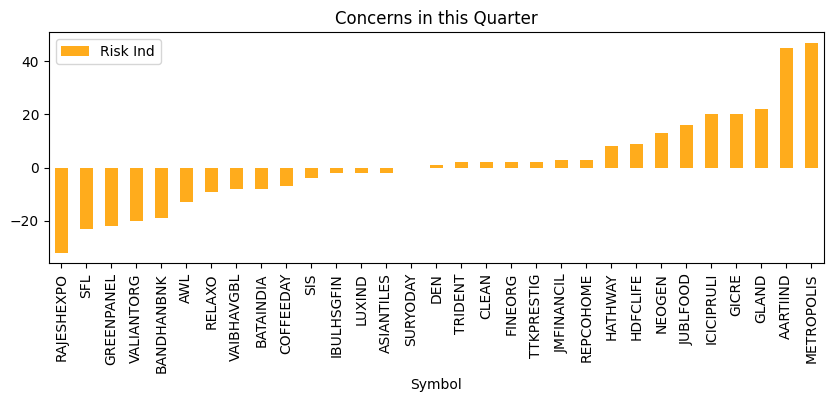

In [19]:
# concerns for this quarter
tmp_df = df_portfolio_features[(df_portfolio_features['LatestQtr'] == 1) & (df_portfolio_features['StarStock'] == 0)].sort_values(by = 'Risk Ind', ascending=True)
print('qualified stocks: '+str(tmp_df.shape[0]))
tmp_df.plot.bar(y='Risk Ind', x = 'Symbol',  figsize=(10, 3), color='#FFAC1C', title='Concerns in this Quarter')

In [20]:
def plot_features_top_bottom(df_portfolio_features, column):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=False).head(5)
  tmp_df.plot.bar(y=column, x = 'Symbol',  figsize=(10, 3), color='#4CBB17', title='Top 5 in ' + column, ax=ax1)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=True).head(5)
  tmp_df.plot.bar(y=column, x = 'Symbol', figsize=(10, 3), color='#FFAC1C', title='Bottom 5 in ' + column, ax=ax2)

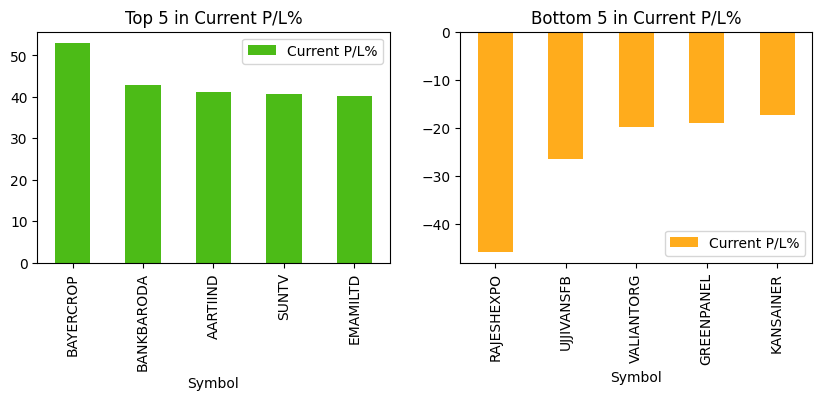

In [21]:
col = 'Current P/L%'
plot_features_top_bottom(df_portfolio_features, col)

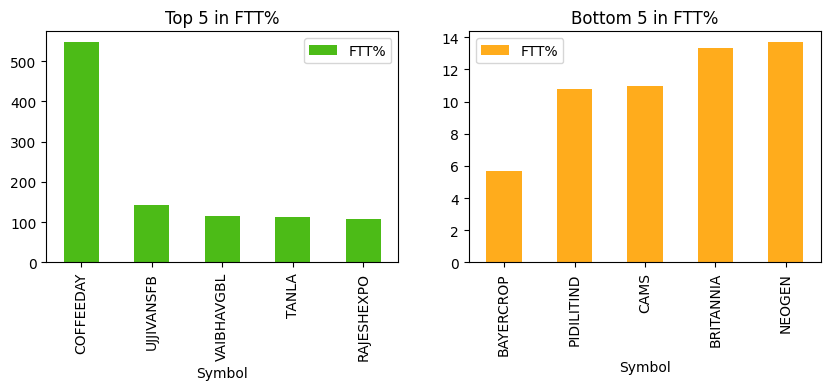

In [22]:
col = 'FTT%'
plot_features_top_bottom(df_portfolio_features, col)

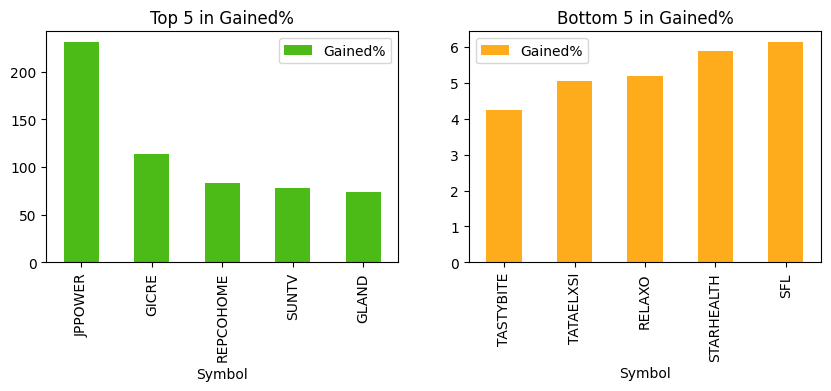

In [23]:
col = 'Gained%'
plot_features_top_bottom(df_portfolio_features, col)

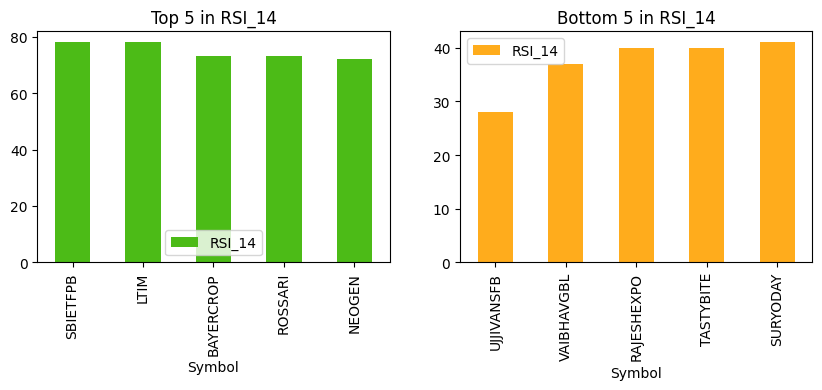

In [24]:
col = 'RSI_14'
plot_features_top_bottom(df_portfolio_features, col)

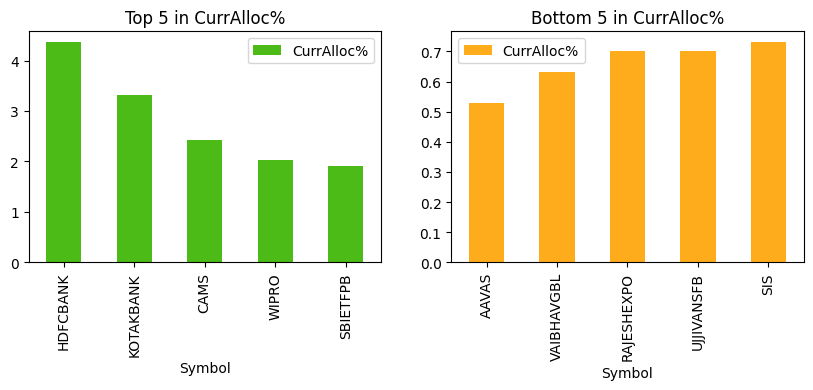

In [25]:
col = 'CurrAlloc%'
plot_features_top_bottom(df_portfolio_features, col)

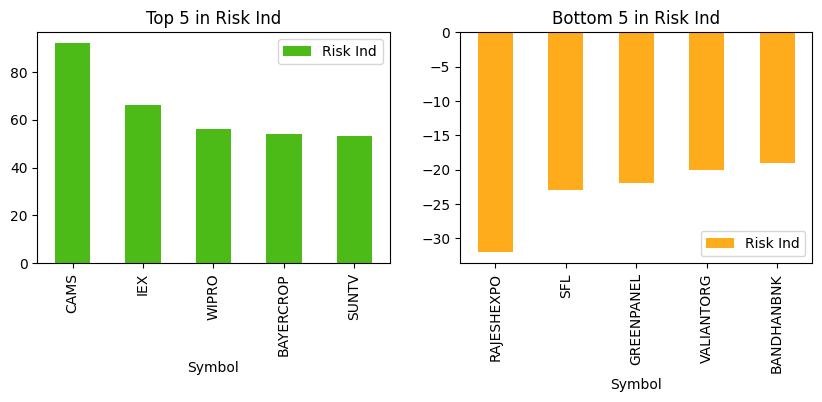

In [26]:
col = 'Risk Ind'
plot_features_top_bottom(df_portfolio_features, col)

In [27]:
def plot_feature_weights(df_portfolio_features, column):
  tmp_df = df_portfolio_features.groupby(column)['CurrAlloc%'].agg(['sum'])
  tmp_df = tmp_df.rename({'sum': 'CurrAlloc%'}, axis='columns')
  tmp_df = tmp_df.sort_values(by = 'CurrAlloc%', ascending=False)
  tmp_df.plot.pie(y='CurrAlloc%', autopct='%1.0f%%', figsize=(5, 5), legend=False, title='CurrAlloc% in ' + column)

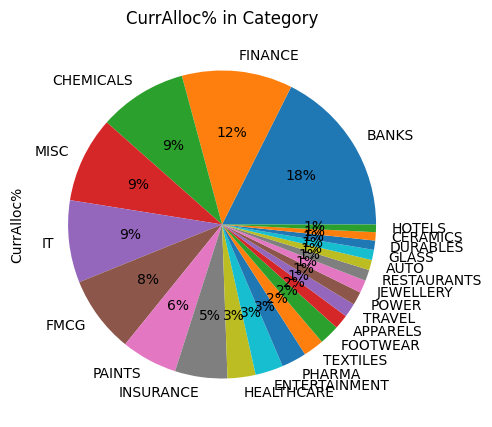

In [28]:
col = 'Category'
plot_feature_weights(df_portfolio_features, col)

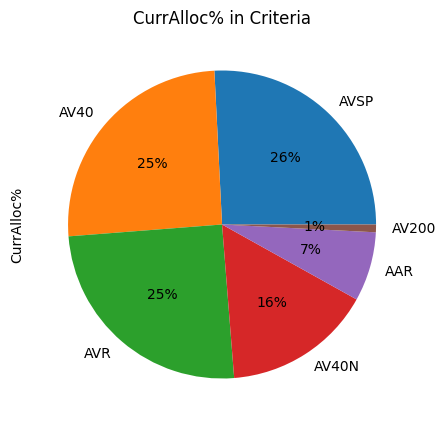

In [29]:
col = 'Criteria'
plot_feature_weights(df_portfolio_features, col)

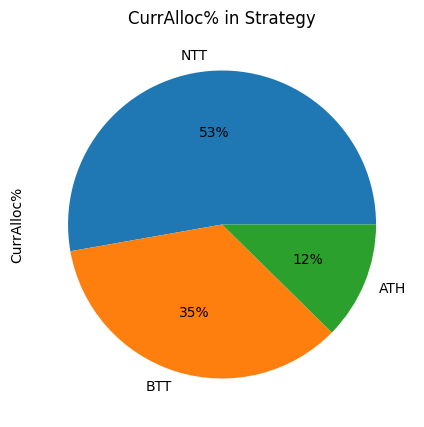

In [30]:
col = 'Strategy'
plot_feature_weights(df_portfolio_features, col)

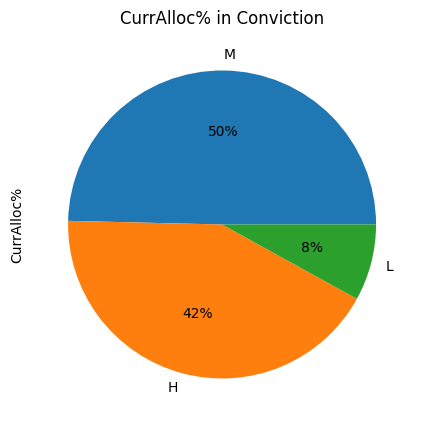

In [31]:
col = 'Conviction'
plot_feature_weights(df_portfolio_features, col)

In [32]:
# stocks to extend in SV account

df_data = df_portfolio_features[~df_portfolio_features["Symbol"].isin(sv_pf['Symbol'].values)]
data_table.DataTable(df_data, include_index=False)


,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
12,BAYERCROP,6653.90,4346.57,7031.00,21.80,16.39,73.0,16,106462.0,36917.0,...,57.96,1.01,9.36,54.0,AV40N,BTT,1,1,M,CHEMICALS
51,NEOGEN,1672.45,1489.90,1901.29,11.42,79.29,72.0,68,113727.0,12414.0,...,40.05,1.08,0.90,13.0,AAR,ATH,1,0,L,CHEMICALS
48,MARICO,611.65,530.08,725.00,12.85,6.81,51.0,200,122330.0,16314.0,...,24.81,1.16,0.83,18.0,AV40,BTT,1,1,H,FMCG
75,UTIAMC,1000.35,946.90,1207.00,15.78,-17.82,58.0,158,158055.0,8445.0,...,41.61,1.49,0.27,8.0,AVSP,NTT,1,1,M,FINANCE
64,SONACOMS,647.35,578.05,800.00,6.30,-0.87,53.0,175,113286.0,12127.0,...,27.80,1.07,0.51,13.0,AAR,NTT,1,1,M,AUTO
34,ICICIPRULI,599.65,508.03,747.00,8.24,28.90,57.0,198,118731.0,18141.0,...,25.20,1.12,0.73,20.0,AV40,BTT,1,0,H,INSURANCE
29,HCLTECH,1454.90,1349.00,1821.00,3.92,22.56,64.0,75,109118.0,7943.0,...,36.45,1.03,0.31,8.0,AV40,BTT,1,1,H,IT
67,SURYODAY,189.97,189.78,240.00,8.55,-34.28,41.0,790,150076.0,150.0,...,29.10,1.42,0.00,0.0,AVR,NTT,1,0,M,BANKS
38,INFY,1573.35,1436.24,1997.00,5.03,-6.07,71.0,104,163628.0,14259.0,...,23.92,1.55,0.35,15.0,AV40,BTT,1,1,H,IT
7,BAJFINANCE,7166.75,7148.10,9150.00,0.44,-34.16,57.0,23,164835.0,429.0,...,14.13,1.56,0.01,0.0,AV40,BTT,1,1,H,FINANCE


In [33]:
# stocks to extend in DM account

df_data = df_portfolio_features[~df_portfolio_features["Symbol"].isin(dm_pf['Symbol'].values)]
data_table.DataTable(df_data, include_index=False)

,Symbol,Close,AvgCost,FTT,Dev%_200,Dev%_PE,RSI_14,Shares,Current,Current P/L,...,Gained%,CurrAlloc%,RRR Ind,Risk Ind,Criteria,Strategy,LatestQtr,StarStock,Conviction,Category
16,BRITANNIA,5430.30,4515.41,6154.00,10.66,10.75,60.0,17,92315.0,15553.0,...,23.49,0.87,1.52,18.0,AAR,BTT,1,1,L,FMCG
14,BIOCON,346.15,291.09,397.00,27.26,-17.13,61.0,516,178613.0,28411.0,...,58.28,1.69,1.29,32.0,AVSP,NTT,1,1,H,PHARMA
20,DABUR,599.30,523.35,710.00,10.17,4.73,58.0,175,104877.0,13291.0,...,21.02,0.99,0.79,14.0,AV40,BTT,1,1,H,FMCG
62,SHALBY,269.05,264.74,327.00,-2.52,NaN,47.0,302,81253.0,1302.0,...,59.83,0.77,0.08,1.0,AVSP,NTT,1,1,H,HEALTHCARE
39,IRCTC,991.25,904.87,1269.00,13.68,2.35,44.0,156,154635.0,13475.0,...,62.04,1.46,0.34,14.0,AVSP,BTT,1,1,H,TRAVEL
1,AARTIIND,687.20,487.04,919.00,13.21,80.31,56.0,167,114762.0,33426.0,...,55.28,1.09,1.22,45.0,AVR,NTT,1,0,M,CHEMICALS
45,LALPATHLAB,2747.95,2519.90,3689.00,12.12,-9.10,61.0,36,98926.0,8210.0,...,36.94,0.94,0.26,9.0,AV40N,NTT,1,1,M,HEALTHCARE
21,DEN,53.18,52.79,75.00,0.34,0.00,51.0,1600,85088.0,624.0,...,59.94,0.80,0.02,1.0,AAR,NTT,1,0,L,ENTERTAINMENT
28,HATHWAY,21.64,19.74,31.40,3.05,65.10,49.0,4000,86560.0,7600.0,...,47.71,0.82,0.21,8.0,AVR,NTT,1,0,M,ENTERTAINMENT
70,TATAELXSI,6997.55,7332.28,10499.44,-8.47,-6.65,44.0,14,97966.0,-4686.0,...,5.05,0.93,-0.09,-4.0,AV40N,ATH,1,1,M,IT


In [34]:
# notebook execution time

end_time = time.time()
execution_time = round(end_time - start_time, 0)
print(f"Notebook execution time: {execution_time} seconds")

Notebook execution time: 71.0 seconds
